In [7]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cv2
from PIL import Image



In [8]:
# === Base directory ===
base_dir = r"C:\Users\vaide\MITResearchWork\G2"
weeks = [7, 9, 11, 13, 15]
group_types = ['UninfectedFront', 'UninfectedBack', 'InfectedFront', 'InfectedBack']

slot_map = {
    7:  {'Uninfected': ['3X', '3R', '3L', '3RR', None], 'Infected': [None, '4R', '4L', '4RR', '4RL']},
    9:  {'Uninfected': ['3X', '3R', '3L', '3RR', None], 'Infected': [None, '4R', '4L', '4RR', '4RL']},
    11: {'Uninfected': ['3X', '3R', '3L', '3RR', None], 'Infected': [None, '4R', '4L', '4RR', '4RL']},
    13: {'Uninfected': ['3X', '3R', '3L', '3RR', None], 'Infected': [None, '4R', '4L', '4RR']},
    15: {'Uninfected': ['3X', '3R', '3L', '3RR', None], 'Infected': [None, '4R', '4L', '4RR', None]},
}


In [3]:
# --- Extract luminescence from 5 slots ---
def extract_luminescence(image_path, n_slots=5):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        return [None] * n_slots
    height, width = img.shape
    slot_width = width // n_slots
    return [np.sum(img[:, i * slot_width:(i + 1) * slot_width]) for i in range(n_slots)]

In [4]:
# --- Find image file (prefer TIF, fallback to PNG) ---
def find_lum_image(folder):
    tif_path = os.path.join(folder, 'luminescent.TIF')
    if os.path.exists(tif_path):
        return tif_path
    for f in os.listdir(folder):
        if f.lower().endswith('.png'):
            return os.path.join(folder, f)
    return None

In [9]:
# --- Build luminescence data ---
lum_data = {}
mouse_status = {}

for week in weeks:
    for status in ['Uninfected', 'Infected']:
        lum_lists = {}

        for side in ['Front', 'Back']:
            folder = os.path.join(base_dir, f'Week{week}', f'{status}{side}')
            image_path = find_lum_image(folder)
            if not image_path:
                continue

            lum_vals = extract_luminescence(image_path)
            mouse_ids = slot_map[week][status]

            for mouse, lum in zip(mouse_ids, lum_vals):
                if mouse:
                    lum_lists.setdefault(mouse, []).append(lum)
                    mouse_status[mouse] = status

        # Average front and back luminescence
        for mouse, lums in lum_lists.items():
            valid = [v for v in lums if v is not None]
            if valid:
                lum_data[(mouse, week)] = np.mean(valid)

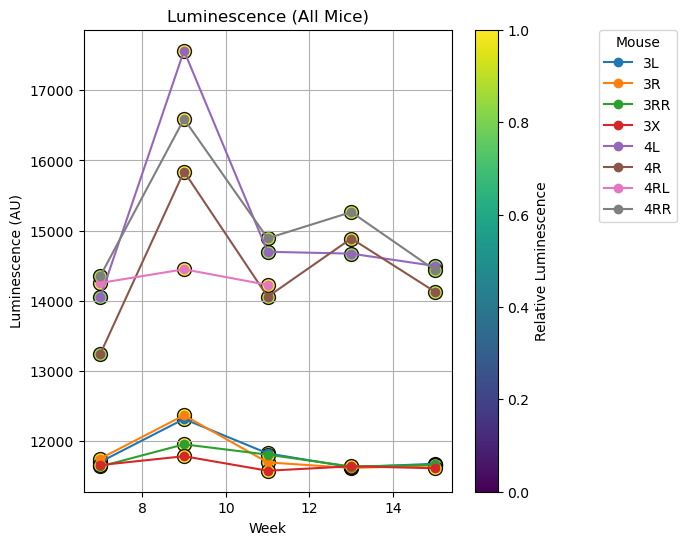

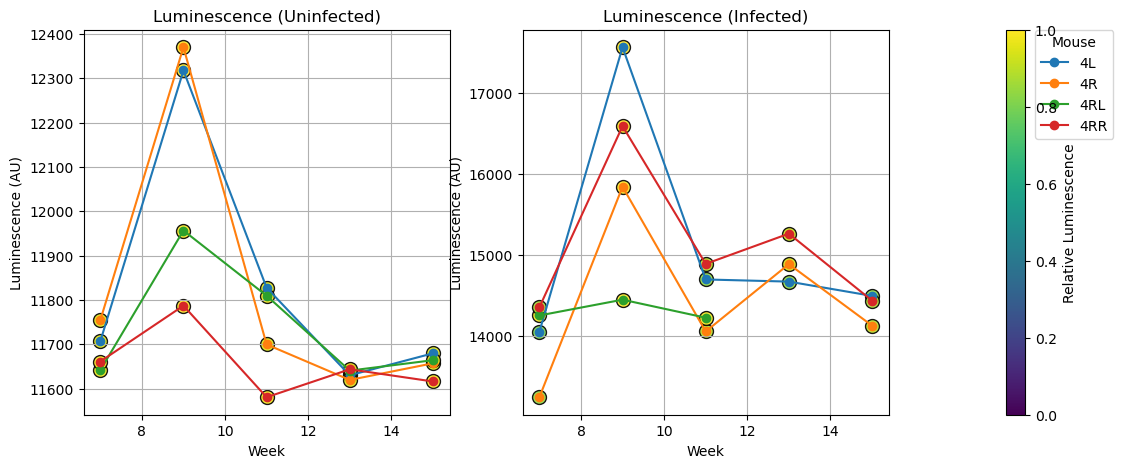

In [10]:
def plot_luminosity(split_by_infection=False):
    fig, axs = (plt.subplots(1, 2, figsize=(14, 5)) if split_by_infection else (plt.figure(figsize=(8, 6)), [plt.gca()]))

    def plot_group(ax, infected_status):
        cmap = cm.viridis
        mice = sorted(set(m for (m, w) in lum_data.keys() if mouse_status[m] == infected_status))

        for mouse in mice:
            entries = sorted([(w, lum_data[(mouse, w)]) for (m, w) in lum_data.keys() if m == mouse], key=lambda x: x[0])
            weeks_sorted = [w for (w, v) in entries]
            lums_sorted = [v for (w, v) in entries]

            lum_max = max(lums_sorted) if lums_sorted else 1

            ax.plot(weeks_sorted, lums_sorted, marker='o', label=mouse)

            for w, lum in zip(weeks_sorted, lums_sorted):
                color = cmap(lum / lum_max)
                ax.scatter(w, lum, s=100, color=color, edgecolor="k", alpha=0.9)

        ax.set_xlabel("Week")
        ax.set_ylabel("Luminescence (AU)")
        ax.grid(True)

        # Legend outside with extra spacing
        handles, labels = ax.get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        ax.legend(
            by_label.values(), by_label.keys(),
            title='Mouse',
            bbox_to_anchor=(1.4, 1),
            loc='upper left',
            borderaxespad=0
        )

    if split_by_infection:
        axs[0].set_title("Luminescence (Uninfected)")
        plot_group(axs[0], infected_status="Uninfected")

        axs[1].set_title("Luminescence (Infected)")
        plot_group(axs[1], infected_status="Infected")

        plt.colorbar(cm.ScalarMappable(cmap=cm.viridis), ax=axs, label="Relative Luminescence")
        plt.subplots_adjust(right=0.7)
        plt.show()
    else:
        axs[0].set_title("Luminescence (All Mice)")
        for status in ["Uninfected", "Infected"]:
            plot_group(axs[0], infected_status=status)

        plt.colorbar(cm.ScalarMappable(cmap=cm.viridis), ax=axs[0], label="Relative Luminescence")
        plt.subplots_adjust(right=0.7)
        plt.show()

# --- Run plots ---
plot_luminosity(split_by_infection=False)  # all mice
plot_luminosity(split_by_infection=True)   # split by infection